In [1]:
import logging
import os
import pdb
from pathlib import Path

import cartopy
import cartopy.crs as ccrs
import matplotlib.colors as colors
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import metpy
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import xarray
from IPython.display import Image  # animated gif
from tqdm import tqdm

import G211
from ml_functions import brier_skill_score, get_args, get_flash_pred
from statisticplot import ax_features, make_map, stat_plots

sns.set_theme()

logging.basicConfig(level=logging.WARNING, format="%(asctime)s %(message)s", force=True)

2024-08-13 11:13:24.167935: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-13 11:13:24.234674: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tmpdir = Path(os.getenv("TMPDIR"))
# map projection
map_crs = G211.g211
grid = G211.grid
conus_mask = G211.mask
dpi=200

obsvar = "cg"
o_thresh = 1
twin = 4
rptdist = 20
clobber = False

platform = "glm" if obsvar == "flashes" else "wbug"
f = f"{obsvar}_{rptdist}km_{twin}hr"

args = get_args(o_thresh, twin)

args

Namespace(batchnorm=True, batchsize=1024, clobber=False, debug=False, dropout=0.0, epochs=30, labels=['cg_20km_4hr', 'ic_20km_4hr', 'cg.ic_20km_4hr', 'flashes_20km_4hr', 'cg_40km_4hr', 'ic_40km_4hr', 'cg.ic_40km_4hr', 'flashes_40km_4hr'], fhr=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48], fits=None, flash=1, folds=None, kfold=1, idate=None, ifile=None, learning_rate=0.001, model='HRRR', neurons=[1024], nfits=10, nprocs=0, optimizer='Adam', reg_penalty=0.0, savedmodel='/glade/work/ahijevyc/NSC_objects/nn/lightning/001+.4hr', seed=-1, trainstart=Timestamp('2019-10-02 00:00:00'), trainend=Timestamp('2020-12-02 00:00:00'), teststart=Timestamp('2021-01-01 00:00:00'), testend=Timestamp('2022-01-01 00:00:00'), twin=4, suite='default')

In [3]:
Y = get_flash_pred(args, clobber=clobber)

levels = sorted(
    list(set(Y.index.names) - {"fold", "fit"})
)  # sorted puts forecast_hour first
assert levels[0] == "forecast_hour"

2024-08-13 11:13:31,535 read saved model output /glade/derecho/scratch/ahijevyc/tmp/Y.001+4hr.2021-01-01 00:00:00-2022-01-01 00:00:00.par
2024-08-13 11:16:29,490 done


In [4]:
def stats(df, o_thresh):
    labels = df.xs("y_label", axis="columns", level=0) >= o_thresh
    y_pred = df.xs("y_pred", axis="columns", level=0)
    bss = brier_skill_score(labels, y_pred)

    auc = pd.Series(np.nan, index=labels.columns)
    aps = auc.copy()
    TF = labels.nunique() == 2
    if TF.any():
        auc[TF] = sklearn.metrics.roc_auc_score(
            labels.loc[:, TF], y_pred.loc[:, TF], average=None
        )
        aps[TF] = sklearn.metrics.average_precision_score(
            labels.loc[:, TF], y_pred.loc[:, TF], average=None
        )

    df = pd.DataFrame(
        {
            "bss": bss,
            "base_rate": labels.mean(),
            "auc": auc,
            "aps": aps,
            "n": y_pred.count(),
        }
    )
    df.index.name = "class"
    return df


def label_pts(ax):
    if ax.get_xlim()[1] - ax.get_xlim()[0] > 10:
        return ax
    xy = ax.lines[0].get_xydata()
    for x0, y0 in xy:
        ax.text(x0, y0, f"{y0:.4f}", clip_on=True, ha="center", fontsize=7)
    return ax

In [5]:
ensmean = (
    Y.xs(slice(12, 36), level="forecast_hour", drop_level=False)
    .groupby(level=levels)
    .mean()
)

logging.warning("apply stats")
tqdm.pandas()
s = ensmean.groupby("valid_time").apply(stats, o_thresh)

2024-08-13 11:23:26,293 apply stats


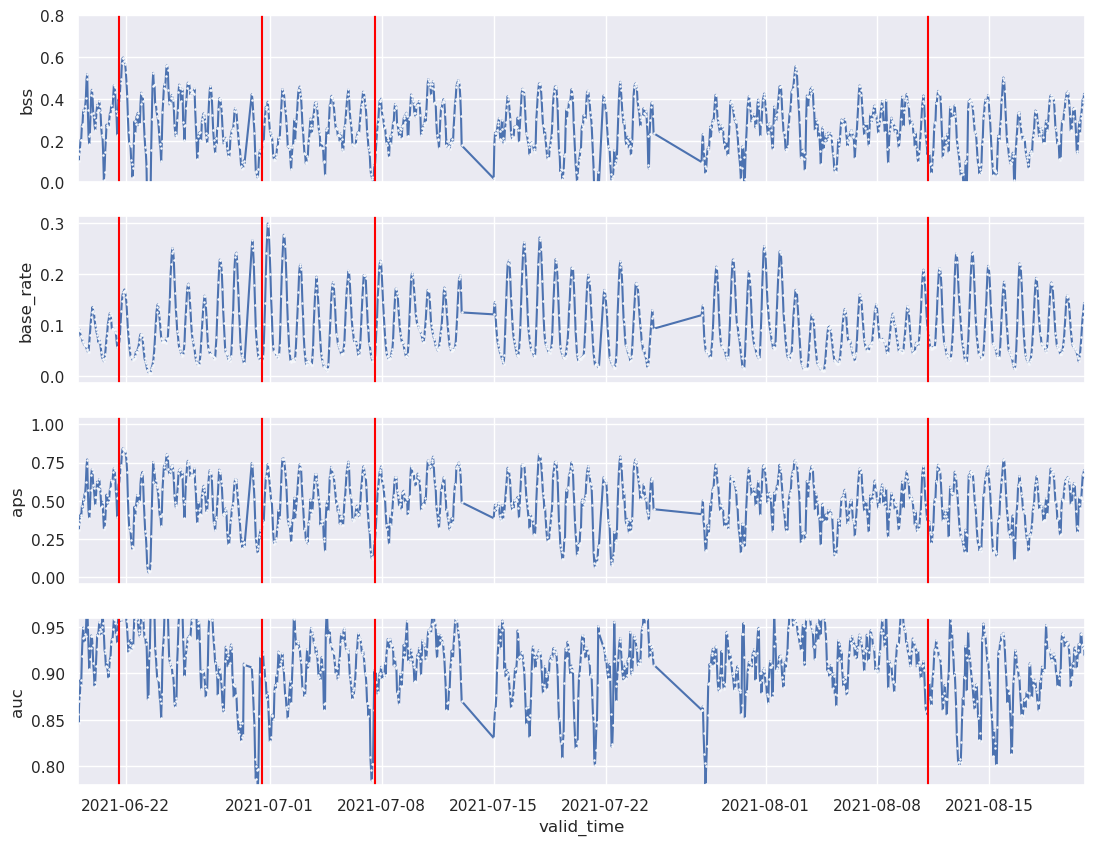

In [6]:
fig, axes = plt.subplots(nrows=4, figsize=(13, 10), sharex=True)
data = s.xs("cg.ic_20km_4hr", level="class")
x = "valid_time"
lkw = dict(
    data = data,
    hue = None,
    x=x,
    markersize=2,
)
ax = sns.lineplot(
    ax=axes[0],
    y="bss",
    **lkw,
)
ax.set_ylim(bottom=0, top=0.8)
if len(ax.lines) > 1:
    sns.move_legend(axes[0], "upper left", bbox_to_anchor=(1, 1))
ax.set_xlim(left=pd.to_datetime("20210619"), right=pd.to_datetime("20210821"))
ax = sns.lineplot(
    ax=axes[1],
    y="base_rate",
    **lkw,
)
sns.lineplot(
    ax=axes[2],
    y="aps",
    **lkw,
)
ax = sns.lineplot(
    ax=axes[3],
    y="auc",
    **lkw,
)
ax.set_ylim((0.78, 0.96))
# ax = sns.lineplot(
#    ax=axes[4],
#    y="n",
#    **lkw,
# )
for ax in axes:
    ax.lines[0].set_marker(".")
    ax.axvline(x=pd.to_datetime("20210621T14"), color="red")
    ax.axvline(x=pd.to_datetime("20210630T12"), color="red")
    ax.axvline(x=pd.to_datetime("20210707T14"), color="red")
    ax.axvline(x=pd.to_datetime("20210811T04"), color="red")

    label_pts(ax)

forecast hours [28]
/glade/derecho/scratch/ahijevyc/tmp/nnpf_o.png


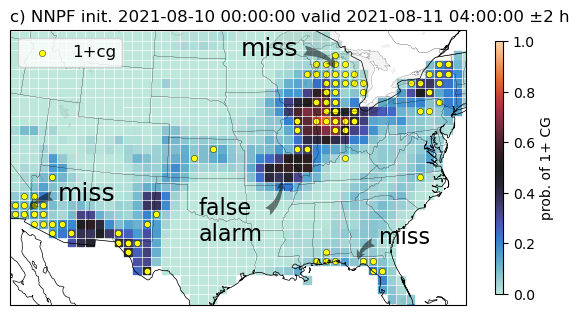

In [7]:
sns.reset_defaults()
o_kw = {
    "marker": "o",
    "s": 20,
    "edgecolor": "black",
    "color": "yellow",
    "label": f"{o_thresh}+{obsvar}",
    "linewidths": 0.3,
}
valid_time = pd.to_datetime("2021-08-11 04:00:00")
extent = (-115, -75.5, 26, 47)
df = ensmean.xs(
    valid_time,
    level="valid_time",
    drop_level=False,
)
print(f"forecast hours {df.reset_index().forecast_hour.unique()}")
initial_time = df.index.get_level_values("initialization_time").mean()


def getp(Y):
    """
    probability of no occurences during long time window = product of 1-p for all
    smaller time window pieces
    """

    # multiply members of group (analogous to sum)
    prob_none = (1 - Y).groupby(["y", "x", "lat", "lon"]).prod()
    # 1 minus prob_none = prob of at least one occurence.
    p = 1 - prob_none
    p = p.reset_index()
    return p



fig, ax = make_map(figsize=(6, 3.2), bbox=extent, projection=map_crs, scale=2)
p = getp(df.xs("y_pred", axis="columns", level=0))
obs = df.xs("y_label", axis="columns", level=0)

px = p.plot(
    ax=ax,
    cmap="icefire",
    c=f,
    kind="scatter",
    x="lon",
    y="lat",
    s=29,
    marker="s",
    transform=ccrs.PlateCarree(),
    vmax=1,
    colorbar=False,
)
fig.colorbar(px.collections[0], shrink=0.9, aspect=30, label=f"prob. of {o_thresh}+ {obsvar.upper()}")

ax.set_title(
    f"c) NNPF init. {initial_time} valid {valid_time} ±{twin/2:.0f} h", loc="left"
)

o = (obs.groupby(["y", "x", "lat", "lon"]).sum() >= o_thresh).reset_index()
io = obs.groupby(["y", "x"]).sum()[f].values > o_thresh
ox = o.loc[io].plot(
    ax=ax,
    kind="scatter",
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    **o_kw,
)
ax.annotate('miss',
            xy=(-114.4, 33.2), xycoords='data',
            xytext=(-112, 34.5), textcoords='data',
            size=18,
            transform=ccrs.PlateCarree(),
            arrowprops=dict(arrowstyle="fancy",
                            fc="0", ec="none",
                            alpha=0.5,
                            connectionstyle="angle3,angleA=0,angleB=-90"))
ax.annotate('miss',
            xy=(-85.4, 44.8), xycoords='data',
            xytext=(-95., 46.2), textcoords='data',
            size=18,
            transform=ccrs.PlateCarree(),
            arrowprops=dict(arrowstyle="fancy",
                            fc="0", ec="none",
                            alpha=0.5,
                            connectionstyle="angle3,angleA=0,angleB=-90"))
ax.annotate('false\nalarm',
            xy=(-91.1, 37.), xycoords='data',
            xytext=(-60, -45), textcoords='offset points',
            size=16,
            transform=ccrs.PlateCarree(),
            arrowprops=dict(arrowstyle="fancy",
                            fc="0", ec="none",
                            alpha=0.5,
                            connectionstyle="angle3,angleA=0,angleB=-90"))

ax.annotate('miss',
            xy=(-84.5, 30.2), xycoords='data',
            xytext=(-82.5, 31.5), textcoords='data',
            size=16,
            transform=ccrs.PlateCarree(),
            arrowprops=dict(arrowstyle="fancy",
                            fc="0", ec="none",
                            alpha=0.5,
                            connectionstyle="angle3,angleA=0,angleB=-90"))
leg = ox.legend(loc="upper left", fontsize="large")
ofile = tmpdir / "nnpf_o.png"
plt.tight_layout()
fig.savefig(ofile, dpi=dpi)
print(ofile)
fig

0.155


2024-06-10 15:46:09,815 /glade/derecho/scratch/ahijevyc/tmp/t.png


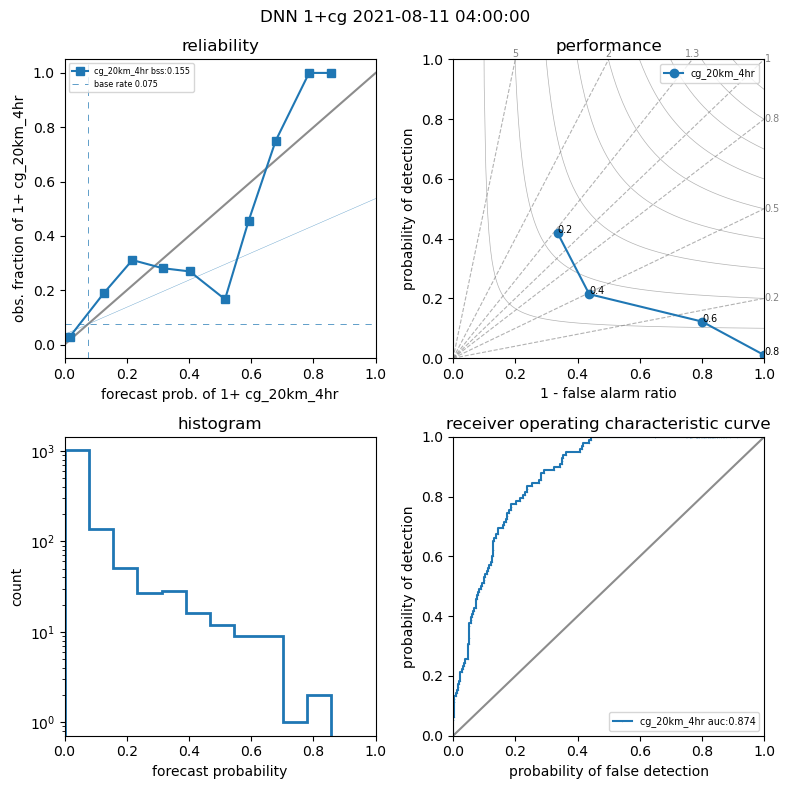

In [8]:
fcst = p[f]
obs = o[f]

fig = stat_plots(
    obs,
    fcst,
    thresh=pd.Series([o_thresh], name=f"{obsvar} threshold"),
    pthresh=pd.Series(np.round(np.arange(0.2, 1, 0.2), 2), name=f"fcst\np thresh"),
    o_thresh_roc=o_thresh,
    sep=0.15,
    n_bins=11,
    suptitle=(f"DNN {o_thresh}+{obsvar} {valid_time}"),
)

ofile = tmpdir / "t.png"
fig.savefig(ofile, dpi=dpi)
logging.warning(ofile)
fig

In [9]:
from zarr_hrrr import ZarrId, load_combined_dataset

history_time = df.index.get_level_values("valid_time").mean().round(freq="1h")

In [10]:
root_url = initial_time.strftime("s3://hrrrzarr/sfc/%Y%m%d/%Y%m%d_%Hz_fcst.zarr")

var_name = "REFC"
var_level = "entire_atmosphere"

zarr_id = ZarrId(
    run_hour=initial_time,
    level_type="sfc",
    var_level=var_level,
    var_name=var_name,
    model_type="fcst",
)
hrrrds = load_combined_dataset([zarr_id])

2024-05-23 16:48:03,569 reading /glade/derecho/scratch/ahijevyc/tmp/HRRR.4hr.2021081000-0000.par 0.1G mtime Fri Apr 19 14:36:21 2024 240 features 8 labels and 4 index_cols & dropna.


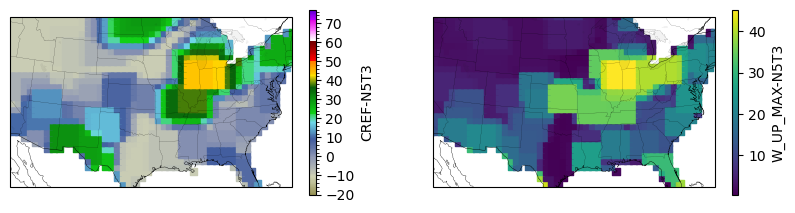

In [11]:
# look at upscaled HRRR features
from ml_functions import load_df
setattr(args, "idate", initial_time)
df = load_df(args)
df = df[df.valid_time == valid_time]

df.columns[::3]

fig, axes = plt.subplots(ncols=2, figsize=(10, 3), subplot_kw=dict(projection=map_crs))
for ax in axes.ravel():
    ax.set_extent(extent)
    ax = ax_features(ax)
ax = axes[0]
coarse_var = "CREF-N5T3"
norm, cmap = metpy.plots.colortables.get_with_steps("NWSStormClearReflectivity", -20, 0.5)

px = p.join(df[coarse_var]).plot(
    ax=ax,
    cmap=cmap,
    norm=norm,
    c=coarse_var,
    kind="scatter",
    x="lon",
    y="lat",
    s=29,
    marker="s",
    transform=ccrs.PlateCarree(),
    colorbar=False,
)
cb=fig.colorbar(px.collections[0], shrink=0.8, aspect=30, label=coarse_var)
cb.ax.minorticks_on()
ax = axes[1]
coarse_var = "W_UP_MAX-N5T3"

px = p.join(df[coarse_var]).plot(
    ax=ax,
    c=coarse_var,
    kind="scatter",
    x="lon",
    y="lat",
    s=29,
    marker="s",
    transform=ccrs.PlateCarree(),
    colorbar=False,
)
cb=fig.colorbar(px.collections[0], shrink=0.8, aspect=30, label=coarse_var)

fig

0 days 00:00:00


/glade/derecho/scratch/ahijevyc/tmp/ipykernel_32707/1753036828.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=(0, 0.25, 1, 1))
2024-04-19 14:20:48,420 /glade/derecho/scratch/ahijevyc/tmp/hrrr.REFC.png


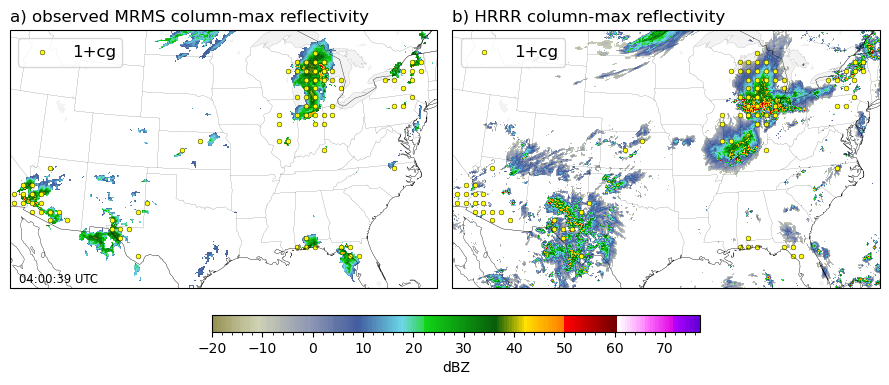

In [32]:
o_kw.update({"s": 12})

sns.reset_defaults()
plt.close("all")
norm, cmap = metpy.plots.colortables.get_with_steps("NWSStormClearReflectivity", -20, 0.5)
idir = Path(os.getenv("SCRATCH")) / "nsslMosaic/mdv/nsslCompositeRefl"

nrows = 1
fig, axes = plt.subplots(ncols=2, nrows=nrows, figsize=(9, nrows*5.2), subplot_kw={"projection": map_crs})

for irow, row in enumerate(np.atleast_2d(axes)):
    ax = row[0]
    dt = pd.Timedelta(hours=-(nrows/2-0.5)+irow)
    print(dt)
    this_time = valid_time + dt
    ifiles = idir.glob(this_time.strftime("%Y%m%d/%H%M??.nc"))
    ifile = list(ifiles)[0]  # generator to list to element
    ds = xarray.open_dataset(ifile, cache=False)
    data_var = ds.metpy.parse_cf("MREF")
    x = data_var.x0
    y = data_var.y0
    im_data = data_var.isel(time=0)
    if hasattr(im_data, "z0"):
        im_data = im_data.isel(z0=0)
    
    im_data = im_data.where(im_data > -30.5, np.nan)
    
    norm, cmap = metpy.plots.colortables.get_with_steps("NWSStormClearReflectivity", -20, 0.5)
    radar = ax.imshow(
        im_data,
        regrid_shape=(3500),
        extent=(x.min(), x.max(), y.max(), y.min()),
        cmap=cmap,
        norm=norm,
        transform=ccrs.PlateCarree(),
    )
    fineprint = ax.text(
        0.02,
        0.02,
        ds.time.dt.strftime("%H:%M:%S UTC").data[0],
        fontsize="small",
        transform=ax.transAxes,
    )
    
    ax.set_title("a) observed MRMS column-max reflectivity", loc="left")
    
    ax = row[1]
    cvar = hrrrds.sel(reference_time=initial_time, time=history_time+dt)[var_name]
    cvar.where(cvar > -10).plot(
        ax=ax,
        cmap=cmap,
        norm=norm,
        add_colorbar=False,
    )
    
    ax.set_title("")  # erase default at loc="center"
    ax.set_title("b) HRRR column-max reflectivity", loc="left")

cb = fig.colorbar(radar, ax=axes, label="dBZ", orientation="horizontal", aspect=30, shrink=0.7)
cb.ax.minorticks_on()

for ax in axes.ravel():
    ox = (
        o.loc[io]
        .plot(
            ax=ax,
            kind="scatter",
            x="lon",
            y="lat",
            transform=ccrs.PlateCarree(),
            **o_kw,
            # legend=False, # placement takes forever
        )
        .legend(loc="upper left", fontsize="large")
    )
    ax = ax_features(ax)
    ax.set_extent(extent)
ofile = tmpdir / f"hrrr.{var_name}.png"
plt.tight_layout(rect=(0, 0.25, 1, 1))
plt.savefig(ofile, dpi=dpi)
logging.warning(ofile)
fig

In [ ]:
ds

In [ ]:
import urllib.request

from PIL import Image as pImage

images = [
    urllib.request.urlretrieve(
        t.strftime(
            "https://www2.mmm.ucar.edu/imagearchive1/RadarComposites/national/%Y%m%d/national_%Y%m%d%H%M.gif"
        ),
        tmpdir / t.strftime("%Y%m%d%H%M.gif"),
    )
    for t in pd.date_range(
        start=valid_time - pd.Timedelta(hours=twin) / 2,
        end=valid_time + pd.Timedelta(hours=twin) / 2,
        freq="30min",
    )
]

In [ ]:
frames = [pImage.open(image) for image, msg in images]
frame_one = frames[0]
ofile = tmpdir / "anim.gif"
frame_one.save(
    ofile, format="GIF", append_images=frames, save_all=True, duration=250, loop=0
)
logging.warning(ofile)
Image(open(ofile, "rb").read())